# Import libraries and data

In [399]:
# Import libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Connect to PostgreSQL server
import os
from dotenv import load_dotenv
load_dotenv()
from pangres import upsert
from sqlalchemy import text, create_engine

db_username = os.environ.get('db_username')
db_password = os.environ.get('db_password')
db_host = os.environ.get('db_host')
db_port = os.environ.get('db_port')
db_name = os.environ.get('db_name')

def create_db_connection_string(db_username, db_password, db_host, db_port, db_name):
    connection_url = 'postgresql+psycopg2://' + db_username + ':' + db_password + '@' + db_host + ':' + db_port + '/' + db_name
    return connection_url

conn = create_db_connection_string(db_username, db_password, db_host, db_port, db_name)

db_engine = create_engine(conn, pool_recycle = 3600)

# Create DataFrame
with db_engine.connect() as connection:
    df = pd.read_sql(text('select * from soloq.matchesv2'), connection)


# Data Cleaning

In [400]:
# Dropping remade games
df = df[df['gameEndedInEarlySurrender'] == False]

# Dropping duplicate games -> impossible to have an exact game so must be error
df.drop_duplicates()

# Check for null values
df.isna().sum()

uuid                         0
totalHealsOnTeammates        0
largestCriticalStrike        0
damageSelfMitigated          0
bountyLevel                  0
                            ..
totalTimeSpentDead           0
gameEndedInEarlySurrender    0
gameEndedInSurrender         0
teamEarlySurrendered         0
win                          0
Length: 96, dtype: int64

No null values thankfully...

## Mapping item and summoner spell ids to actual names

In [328]:
import requests

# Replacing item ids with name in game
items = "https://raw.communitydragon.org/latest/plugins/rcp-be-lol-game-data/global/default/v1/items.json"
items_json = requests.get(items).json()

# Replacing summoner spell ids with name in game
summoner_spells = "https://raw.communitydragon.org/latest/plugins/rcp-be-lol-game-data/global/default/v1/summoner-spells.json"
summoner_spells_json = requests.get(summoner_spells).json()

def json_extract(obj, key):

    arr = []

    def extract(obj, arr, key):
        if isinstance(obj, dict):
            for k, v in obj.items():
                if k == key:
                    arr.append(v)
                elif isinstance(v, (dict, list)):
                    extract(v, arr, key)
        elif isinstance(obj, list):
            for item in obj:
                extract(item, arr, key)

        return arr
    
    values = extract(obj, arr, key)
    return values

item_ids = json_extract(items_json, 'id')
item_names = json_extract(items_json, 'name')

summoner_spell_ids = json_extract(summoner_spells_json, 'id')
summoner_spell_names = json_extract(summoner_spells_json, 'name')

item_dict = dict(map(lambda i, j :(i, j), item_ids, item_names))
summoner_spell_dict = dict(map(lambda i, j :(i, j), summoner_spell_ids, summoner_spell_names))

In [329]:
# Map to features
item_features = ['item0', 'item1', 'item2', 'item3', 'item4', 'item5', 'item6']
summoner_spell_features = ['summoner1Id', 'summoner2Id']

df[summoner_spell_features] = df[summoner_spell_features].replace(summoner_spell_dict)
df[item_features] = df[item_features].replace(item_dict)

# Exploratory Data Analysis

In [330]:
# All column names
df.columns

Index(['uuid', 'totalHealsOnTeammates', 'largestCriticalStrike',
       'damageSelfMitigated', 'bountyLevel', 'consumablesPurchased',
       'spell1Casts', 'spell2Casts', 'spell3Casts', 'spell4Casts',
       'summoner1Casts', 'summoner1Id', 'summoner2Casts', 'summoner2Id',
       'matchId', 'teamId', 'gameDuration', 'gameVersion', 'summonerName',
       'puuid', 'lane', 'role', 'summonerLevel', 'teamPosition',
       'champExperience', 'champLevel', 'championName', 'kills', 'deaths',
       'assists', 'doubleKills', 'tripleKills', 'quadraKills', 'pentaKills',
       'largestKillingSpree', 'largestMultiKill', 'killingSprees',
       'firstBloodAssist', 'firstBloodKill', 'unrealKills', 'totalDamageDealt',
       'totalDamageDealtToChampions', 'totalDamageShieldedOnTeammates',
       'totalDamageTaken', 'totalHeal', 'trueDamageDealt',
       'trueDamageDealtToChampions', 'trueDamageTaken', 'magicDamageDealt',
       'magicDamageDealtToChampions', 'magicDamageTaken',
       'physicalDamage

In [331]:
df.shape

(193750, 96)

In [332]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193750 entries, 0 to 198839
Data columns (total 96 columns):
 #   Column                          Non-Null Count   Dtype 
---  ------                          --------------   ----- 
 0   uuid                            193750 non-null  object
 1   totalHealsOnTeammates           193750 non-null  int64 
 2   largestCriticalStrike           193750 non-null  int64 
 3   damageSelfMitigated             193750 non-null  int64 
 4   bountyLevel                     193750 non-null  int64 
 5   consumablesPurchased            193750 non-null  int64 
 6   spell1Casts                     193750 non-null  int64 
 7   spell2Casts                     193750 non-null  int64 
 8   spell3Casts                     193750 non-null  int64 
 9   spell4Casts                     193750 non-null  int64 
 10  summoner1Casts                  193750 non-null  int64 
 11  summoner1Id                     193750 non-null  object
 12  summoner2Casts                  193

## Top features in determining champion

Initial guesses based on game knowledge
1. Lane
2. KDA
3. Damage dealt
4. Type of damage dealt
5. Itemization
6. Shielding/healing
7. Damage to towers
8. Objective kills, wards placed?
9. Buttons pressed?

# Feature correlation with game time

<Axes: >

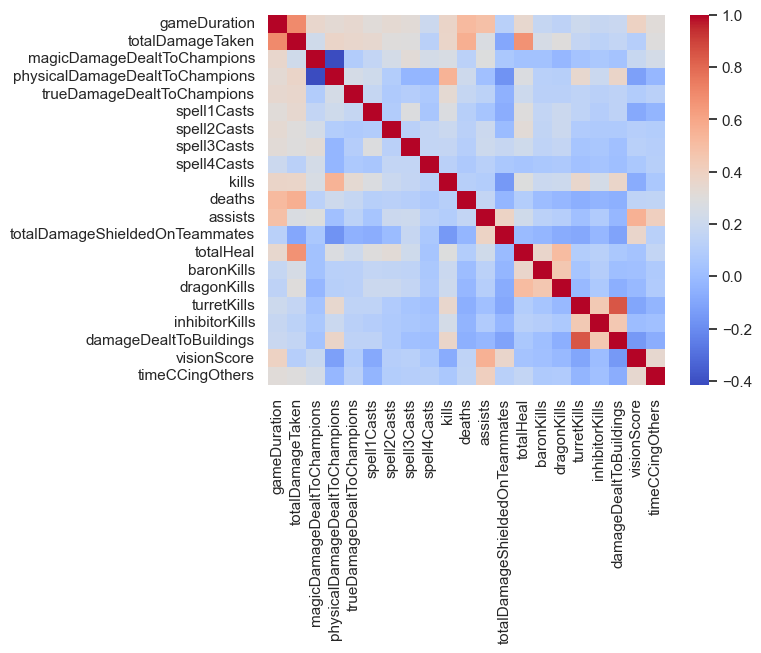

In [353]:
corr = df[['gameDuration', 'totalDamageTaken', 'magicDamageDealtToChampions',
    'physicalDamageDealtToChampions', 'trueDamageDealtToChampions',
      'spell1Casts', 'spell2Casts', 'spell3Casts', 'spell4Casts',
      'kills', 'deaths','assists',
      'totalDamageShieldedOnTeammates','totalHeal',
      'baronKills', 'dragonKills', 'turretKills', 'inhibitorKills', 'damageDealtToBuildings',
      'visionScore', 'timeCCingOthers'
      ]].corr()

sns.heatmap(corr, cmap = 'coolwarm' )

Know from playing the game that champions usually have an intended lane to play

In [333]:
df[['championName', 'lane']].value_counts()

championName  lane  
MissFortune   BOTTOM    3641
Smolder       BOTTOM    3277
Jhin          BOTTOM    3094
Senna         BOTTOM    2574
Caitlyn       BOTTOM    2546
                        ... 
Orianna       JUNGLE       2
Nami          TOP          2
Olaf          BOTTOM       2
Hecarim       MIDDLE       1
Braum         JUNGLE       1
Name: count, Length: 834, dtype: int64

# Items

In [334]:
df[['championName', 'item1']][df['championName'] == 'Zac'].value_counts()

championName  item1                   
Zac           Sunfire Aegis               427
              Hollow Radiance              93
              Plated Steelcaps             82
              Ionian Boots of Lucidity     79
              Thornmail                    73
                                         ... 
              Mobility Boots                1
              Spear of Shojin               1
              Sorcerer's Shoes              1
              Morellonomicon                1
              Crystalline Bracer            1
Name: count, Length: 64, dtype: int64

In [335]:
items = ['item0', 'item1', 'item2', 'item3', 'item4', 'item5', 'item6']
for item in items:
    print(df[['championName', item]].value_counts()[:5])

championName  item0               
Lux           Zaz'Zak's Realmspike    1555
Senna         Bloodsong               1264
Zyra          Zaz'Zak's Realmspike    1075
Caitlyn       Doran's Blade            984
MissFortune   Youmuu's Ghostblade      975
Name: count, dtype: int64
championName  item1              
Smolder       Essence Reaver         1579
MissFortune   Youmuu's Ghostblade    1488
Yasuo         Berserker's Greaves    1162
Yone          Berserker's Greaves    1138
Jhin          Youmuu's Ghostblade    1038
Name: count, dtype: int64
championName  item2                   
Smolder       Ionian Boots of Lucidity    1278
Jhin          Boots of Swiftness          1216
Lux           Sorcerer's Shoes            1202
Caitlyn       Berserker's Greaves         1132
Brand         Sorcerer's Shoes            1002
Name: count, dtype: int64
championName  item3                   
MissFortune   The Collector               963
Smolder       Navori Quickblades          957
Jhin          The Colle

# Damage

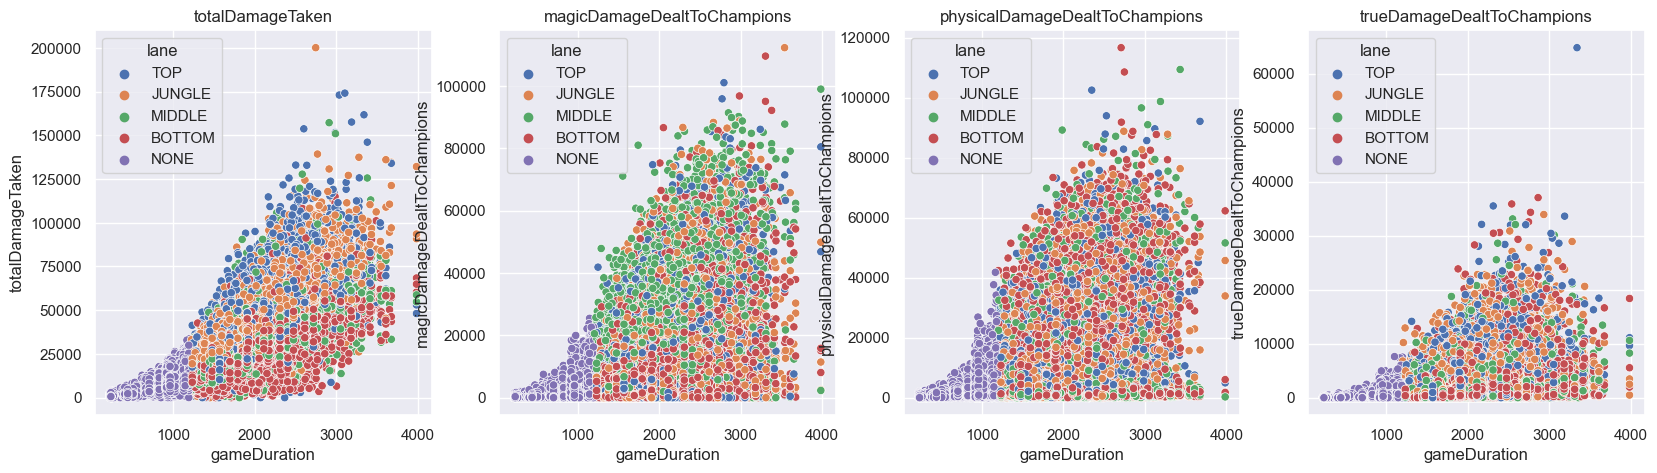

In [336]:
damage = ['totalDamageTaken', 'magicDamageDealtToChampions', 'physicalDamageDealtToChampions', 'trueDamageDealtToChampions']
fig, axs = plt.subplots(1, len(damage), figsize=(20, 5))
for i, feature in enumerate(damage):
    sns.scatterplot(data = df, x = 'gameDuration', y = feature, hue = 'lane', ax = axs[i])
    axs[i].set_title(feature)

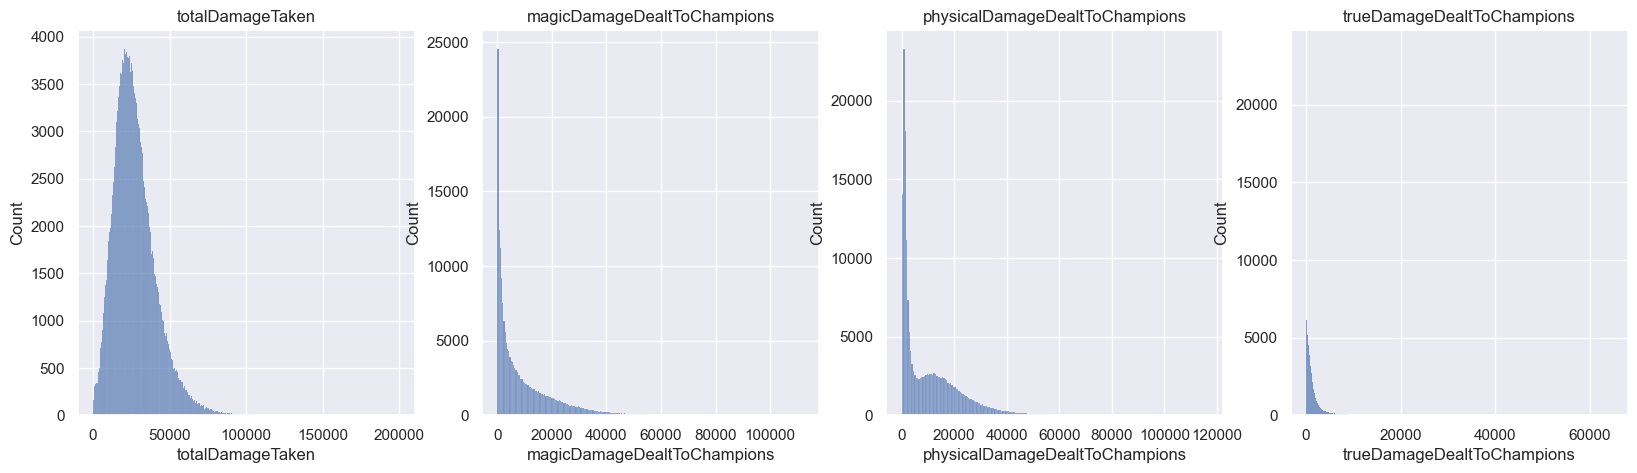

In [337]:
damage = ['totalDamageTaken', 'magicDamageDealtToChampions', 'physicalDamageDealtToChampions', 'trueDamageDealtToChampions']
fig, axs = plt.subplots(1, len(damage), figsize=(20, 5))
for i, feature in enumerate(damage):
    sns.histplot(data = df, x = feature, ax = axs[i])
    axs[i].set_title(feature)

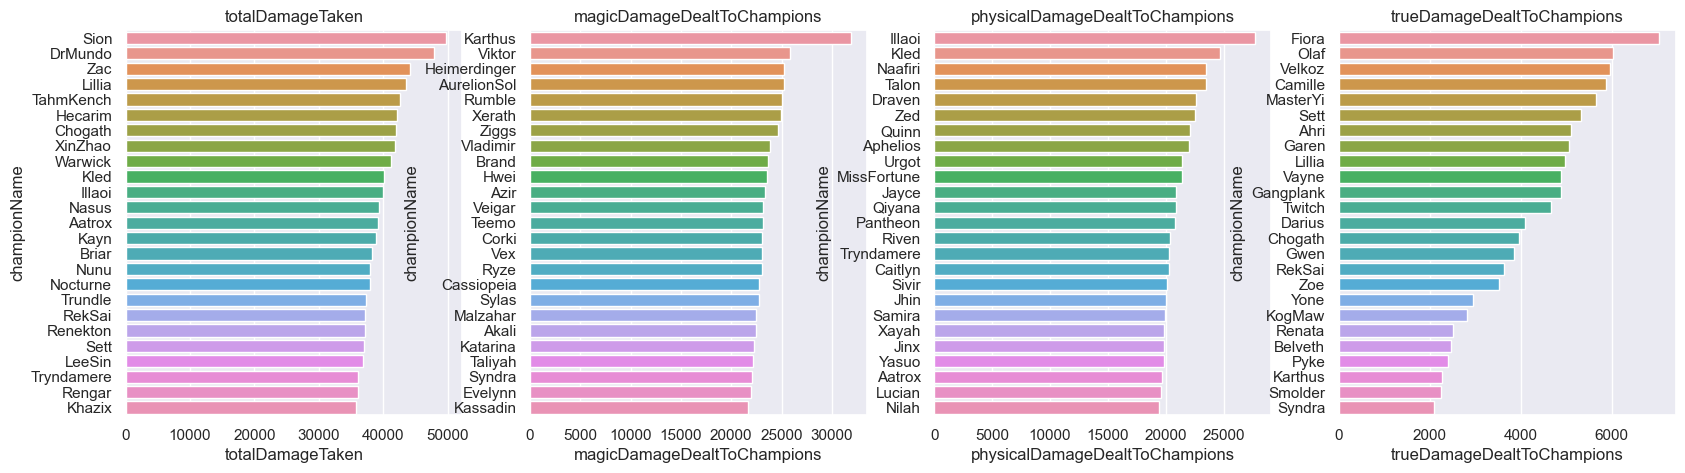

In [338]:
damage = ['totalDamageTaken', 'magicDamageDealtToChampions', 'physicalDamageDealtToChampions', 'trueDamageDealtToChampions']

fig, axs = plt.subplots(1, len(damage), figsize=(20, 5))
for i, feature in enumerate(damage):
    test = df[['championName', feature]].groupby('championName').mean().sort_values(by = feature, ascending = False).reset_index()[:25]
    sns.barplot(data = test, x = feature, y = 'championName', ax = axs[i])
    axs[i].set_title(feature)

# Healing/Shielding

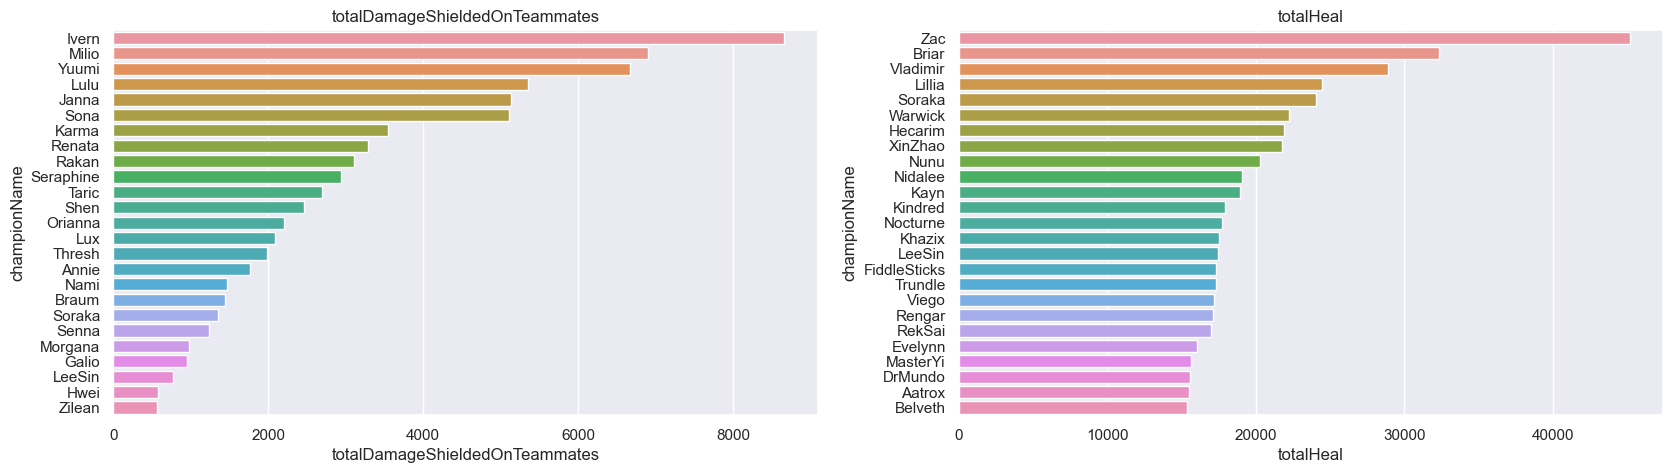

In [339]:
heal_shield = ['totalDamageShieldedOnTeammates','totalHeal']

fig, axs = plt.subplots(1, len(heal_shield), figsize=(20, 5))
for i, feature in enumerate(heal_shield):
    test = df[['championName', feature]].groupby('championName').mean().sort_values(by = feature, ascending = False).reset_index()[:25]
    sns.barplot(data = test, x = feature, y = 'championName', ax = axs[i])
    axs[i].set_title(feature)

# Objectives

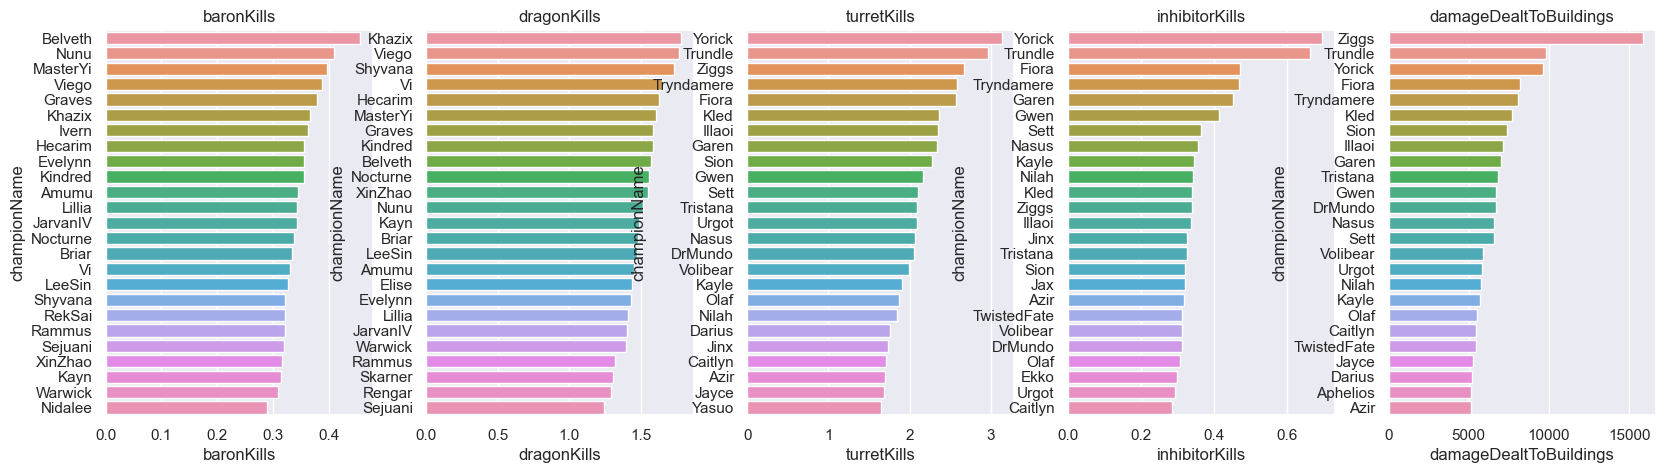

In [340]:
objectives = ['baronKills', 'dragonKills', 'turretKills', 'inhibitorKills', 'damageDealtToBuildings']

fig, axs = plt.subplots(1, len(objectives), figsize=(20, 5))
for i, feature in enumerate(objectives):
    test = df[['championName', feature]].groupby('championName').mean().sort_values(by = feature, ascending = False).reset_index()[:25]
    sns.barplot(data = test, x = feature, y = 'championName', ax = axs[i])
    axs[i].set_title(feature)

# Vision + CC

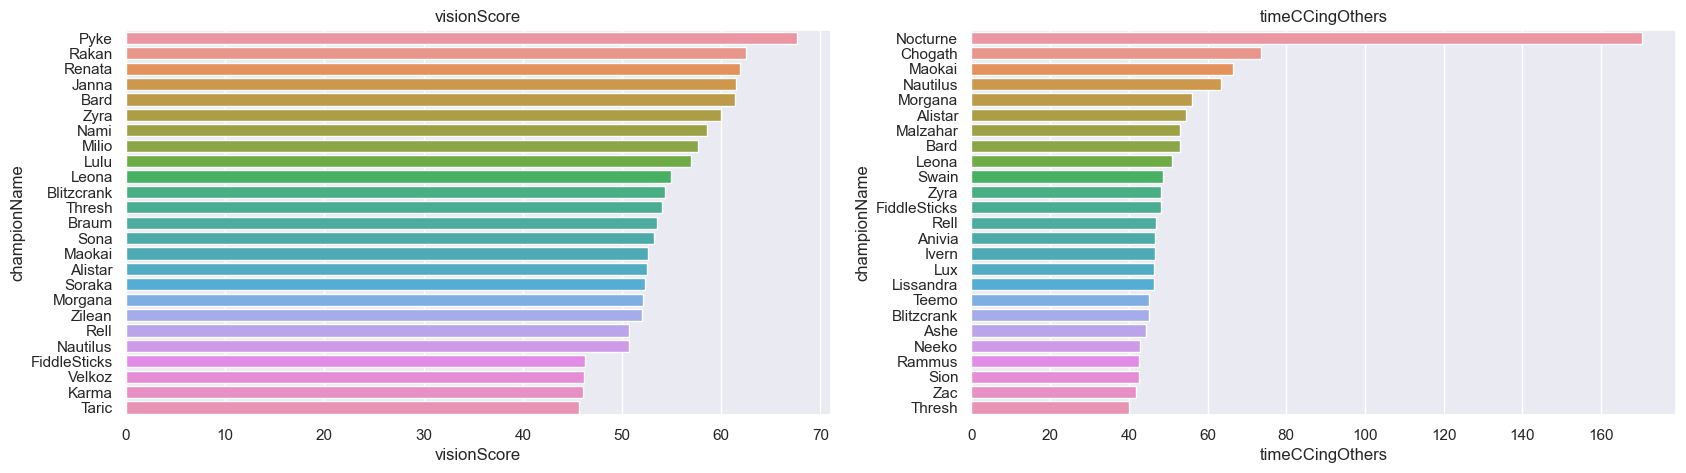

In [341]:
other = ['visionScore', 'timeCCingOthers']

fig, axs = plt.subplots(1, len(other), figsize=(20, 5))
for i, feature in enumerate(other):
    test = df[['championName', feature]].groupby('championName').mean().sort_values(by = feature, ascending = False).reset_index()[:25]
    sns.barplot(data = test, x = feature, y = 'championName', ax = axs[i])
    axs[i].set_title(feature)

Supports generally have higher vision score, heavy cc champions have most time ccing others with nocturne at no. 1 spot since his ult blinds everyone for 5 seconds.

# Spells Casted

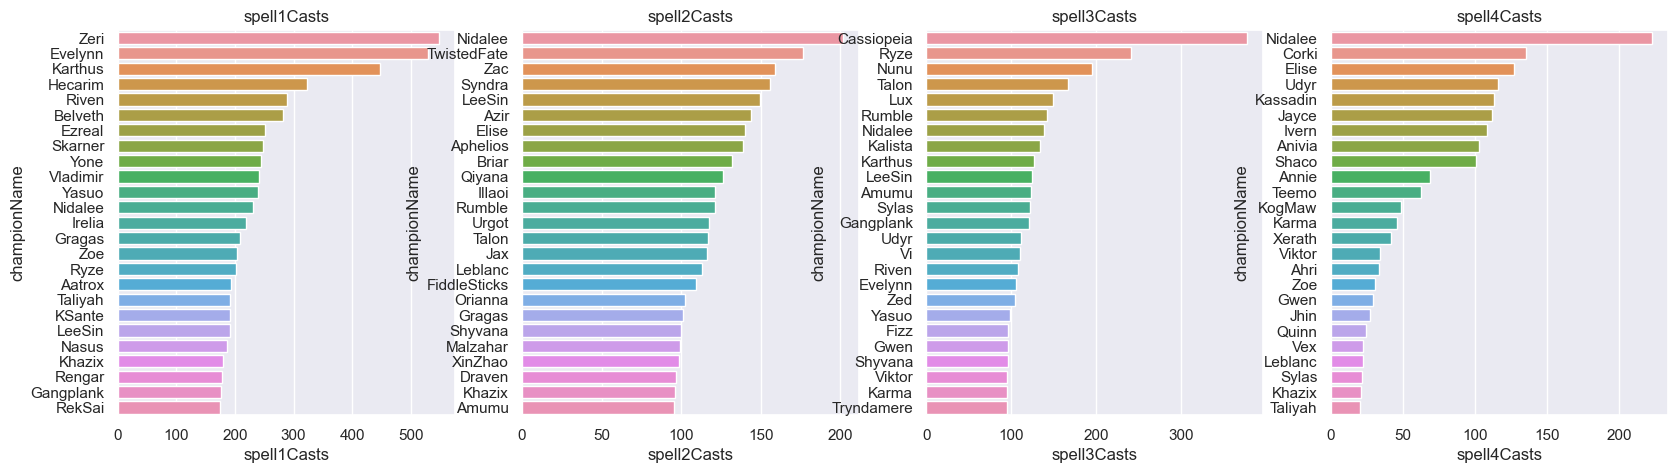

In [342]:
spells = ['spell1Casts', 'spell2Casts', 'spell3Casts', 'spell4Casts']

fig, axs = plt.subplots(1, len(spells), figsize=(20, 5))
for i, feature in enumerate(spells):
    test = df[['championName', feature]].groupby('championName').mean().sort_values(by = feature, ascending = False).reset_index()[:25]
    sns.barplot(data = test, x = feature, y = 'championName', ax = axs[i])
    axs[i].set_title(feature)

Q spam champions have most spell 1 casts (Zeri, Evelynn, Karthus, Hecarim etc.)
W spam -> Nidalee jump, twisted fate card, 
E spam -> Cass fangs, ryze eq combo, nunu snowball, talon jump
R spam -> mostly transform champions + corki rocket and kassdin teleport

We see that certain champions definitely cast certain spells much more than others

# Summoner Spells

<Axes: xlabel='summoner1Id', ylabel='Count'>

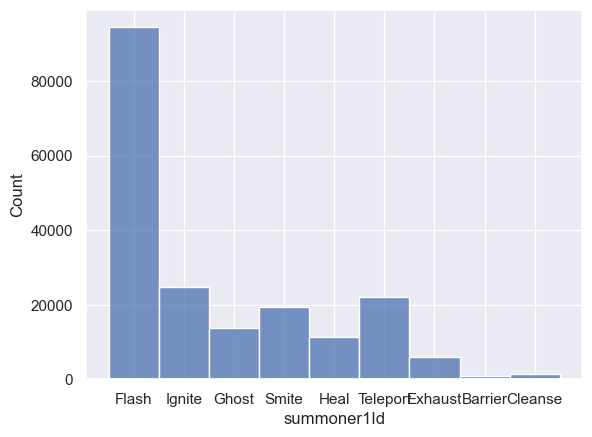

In [343]:
sns.histplot(data = df, x = 'summoner1Id')

# Summoner spells by lane

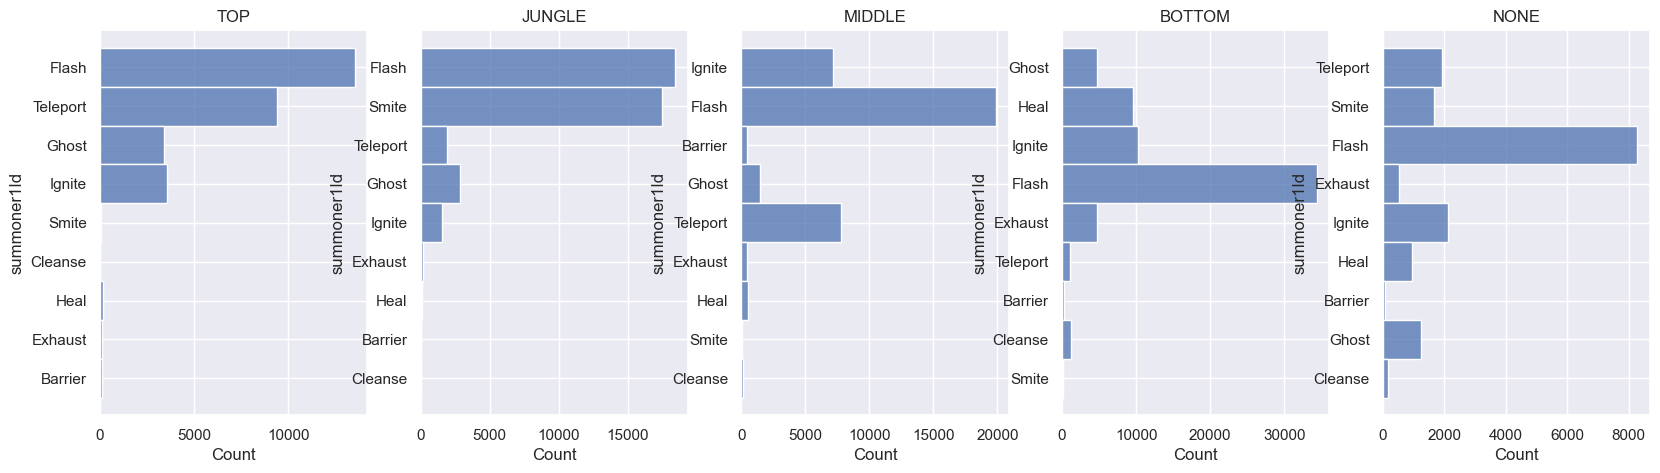

In [344]:
lanes = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'NONE']

fig, axs = plt.subplots(1, len(lanes), figsize=(20, 5))
for i, feature in enumerate(lanes):
    sns.histplot(data = df[df['lane'] == feature], y = 'summoner1Id', ax = axs[i])
    axs[i].set_title(feature)


In [345]:
df[['summoner1Id','summoner2Id']][df['championName'] == 'Singed'].value_counts()

summoner1Id  summoner2Id
Ghost        Flash          150
Flash        Ghost          145
Teleport     Ghost           75
Ghost        Teleport        63
             Ignite          53
Ignite       Ghost           32
Smite        Ghost           18
Ghost        Smite           16
Flash        Ignite          12
             Teleport        11
Ignite       Flash            7
Flash        Smite            4
Smite        Flash            4
Teleport     Flash            4
Ghost        Barrier          1
             Heal             1
Flash        Heal             1
Heal         Flash            1
Exhaust      Ignite           1
Name: count, dtype: int64

In [346]:
df['lane'].value_counts()

lane
BOTTOM    66235
JUNGLE    42466
MIDDLE    37820
TOP       30319
NONE      16910
Name: count, dtype: int64

In [347]:
df['role'].value_counts()

role
SOLO       58874
SUPPORT    49527
NONE       42466
CARRY      32429
DUO        10454
Name: count, dtype: int64

In [348]:
df['teamPosition'].value_counts()

teamPosition
TOP        38744
MIDDLE     38744
JUNGLE     38743
BOTTOM     38739
UTILITY    38737
              43
Name: count, dtype: int64

# Feature Engineering
1. Normalize certain features by game duration
2. Classify champions as AD/AP
3. Classify champions as their class based on itemization?


For sake of simplicity, I am going to address the three features 'role', 'lane', and 'teamPosition' by just simplifying them into one feature where I redefine their lane which can be either 1. TOP 2. JUNGLE 3. MIDDLE 4. ADC 5. SUPPORT to follow traditional League of Legends team compositions

In [402]:
# Normalize games by duration so features on a per second basis (ex. total damage taken per second)
def game_normalize_by_duration(feature_list):
    for feature in feature_list:
        df[feature] = df[feature] / df['gameDuration']

    return df

feature_list = ['totalDamageTaken', 'magicDamageDealtToChampions',
  'physicalDamageDealtToChampions', 'trueDamageDealtToChampions',
  'totalDamageShieldedOnTeammates','totalHeal',
  'spell1Casts', 'spell2Casts',
    'spell3Casts', 'spell4Casts',
    'visionScore', 'timeCCingOthers'
  ]

df = game_normalize_by_duration(feature_list)

# Classifying champions as ap champs if they deal more magic than physical damage
df['ap'] = (df['physicalDamageDealtToChampions'] < df['magicDamageDealtToChampions']).astype(int)

# Same thing for ad
df['ad'] = (df['physicalDamageDealtToChampions'] > df['magicDamageDealtToChampions']).astype(int)

# Objective Kills
df['objective_kills'] = df['baronKills'] + df['dragonKills']

# Building Kills
df['building_kills'] = df['turretKills'] + df['inhibitorKills']

objective_building = ['objective_kills', 'building_kills']

df = game_normalize_by_duration(objective_building)

Class classification:
Enchanter -> Heal and shield
Catcher -> lots of cc
Juggernaut -> tanky but also deal damage
Diver -> kill backline
Burst mages -> Huge amount of AP damage quickly
Battle mages -> Sustained damage over huge area
Artillery -> poke damage
Marksmen -> damage carries, adcs usually
Assassin -> Huge AD damage quickly
Skirmisher -> Duelists -> excel in 1v1
Tank -> absorb most damage 

## ML Pipeline

In [420]:
# Import ML libs
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [421]:
# Filter for important features
important_features = ['lane', 'championName', 'ap', 'ad', 'spell1Casts', 'spell2Casts', 'spell3Casts', 'spell4Casts','totalDamageTaken', 'magicDamageDealtToChampions', 'physicalDamageDealtToChampions', 'trueDamageDealtToChampions', 'objective_kills', 'building_kills']
df = df[important_features]

In [425]:
# Seperate target from features
X = df.drop(columns = ['championName'])
y = df['championName']

# Split train/test
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

# Seperate numeric and categorical features
num_features = X.select_dtypes(include=['float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

# Define transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

# RandomForestClassifier
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# KNN
k = 5
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors = k))
])

# SVM
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC())
])

# Naive-Bayes
nb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

# Logistic Regression
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [429]:
pipelines = {'Random Forest': rf_pipeline,
             'K Nearest Neighbours': knn_pipeline,
             'Support Vector Machines': svm_pipeline,
             'Naive-Bayes': nb_pipeline,
             'Logistic Regression': lr_pipeline
             }

In [430]:
rf_pipeline.fit(train_X, train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['spell1Casts', 'spell2Casts', 'spell3Casts', 'spell4Casts',
       'totalDamageTaken', 'magicDamageDealtToChampions',
       'physicalDamageDealtToChampions', 'trueDamageDealtToChampions',
       'objective_kills', 'building_kills'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['lane'], dtype='object'))])),
                ('classifier', RandomForestClassifier())])

In [431]:
preds = rf_pipeline.predict(val_X)

In [432]:
accuracy_score(preds, val_y)

0.8128741896857838

In [434]:
print(classification_report(preds,val_y))

              precision    recall  f1-score   support

      Aatrox       0.89      0.77      0.83       528
        Ahri       0.97      0.96      0.96       260
       Akali       0.90      0.78      0.84       553
      Akshan       0.78      0.86      0.82       165
     Alistar       0.36      0.48      0.41        90
       Amumu       0.84      0.85      0.84       237
      Anivia       0.90      0.91      0.90       127
       Annie       0.49      0.77      0.60        84
    Aphelios       0.98      0.95      0.96       172
        Ashe       0.96      0.92      0.94       638
 AurelionSol       0.84      0.70      0.76       341
        Azir       0.96      0.94      0.95       179
        Bard       0.77      0.77      0.77       234
     Belveth       0.90      0.92      0.91       258
  Blitzcrank       0.75      0.69      0.72       331
       Brand       0.81      0.77      0.79       816
       Braum       0.50      0.68      0.57        84
       Briar       0.95    

In [435]:
knn_pipeline.fit(train_X, train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['spell1Casts', 'spell2Casts', 'spell3Casts', 'spell4Casts',
       'totalDamageTaken', 'magicDamageDealtToChampions',
       'physicalDamageDealtToChampions', 'trueDamageDealtToChampions',
       'objective_kills', 'building_kills'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['lane'], dtype='object'))])),
                ('classifier', KNeighborsClassifier())])

In [436]:
knn_preds = knn_pipeline.predict(val_X)

In [437]:
print(classification_report(knn_preds,val_y))

              precision    recall  f1-score   support

      Aatrox       0.83      0.59      0.69       642
        Ahri       0.95      0.89      0.92       277
       Akali       0.79      0.57      0.67       669
      Akshan       0.66      0.56      0.60       218
     Alistar       0.33      0.17      0.23       233
       Amumu       0.80      0.68      0.73       281
      Anivia       0.84      0.75      0.79       143
       Annie       0.31      0.39      0.34       104
    Aphelios       0.66      0.71      0.68       154
        Ashe       0.86      0.80      0.83       661
 AurelionSol       0.61      0.36      0.45       479
        Azir       0.76      0.75      0.75       179
        Bard       0.65      0.55      0.60       279
     Belveth       0.86      0.80      0.83       284
  Blitzcrank       0.58      0.43      0.49       416
       Brand       0.74      0.54      0.63      1073
       Braum       0.44      0.41      0.43       124
       Briar       0.90    

In [448]:
pred = preds.tolist()

In [449]:
val = val_y.tolist()

In [451]:
for item1, item2 in zip(pred, val):
    print(f"{item1} \t {item2}")

Rengar 	 Rengar
Tristana 	 Tristana
Orianna 	 Syndra
Gnar 	 Poppy
Irelia 	 Irelia
Swain 	 Swain
MasterYi 	 MasterYi
Lillia 	 Lillia
Zed 	 Zed
Xayah 	 Xayah
Darius 	 Darius
Vayne 	 Vayne
Pyke 	 Pyke
Graves 	 Darius
Maokai 	 Alistar
Varus 	 Varus
Mordekaiser 	 Mordekaiser
Lissandra 	 Lissandra
Zac 	 FiddleSticks
Morgana 	 Morgana
Illaoi 	 Illaoi
Leblanc 	 TwistedFate
MissFortune 	 Graves
Nautilus 	 Nautilus
Renekton 	 Renekton
MissFortune 	 MissFortune
Jhin 	 Jhin
Naafiri 	 Naafiri
Lulu 	 Lulu
Mordekaiser 	 Mordekaiser
Nunu 	 Sylas
Vi 	 Vi
Zac 	 Zac
Ziggs 	 Ziggs
Rengar 	 Rengar
Sion 	 Sion
Kindred 	 Kindred
Samira 	 Samira
Ekko 	 Ekko
Jhin 	 Jhin
Lux 	 Lux
Pantheon 	 Pantheon
Samira 	 Samira
Kayle 	 Kayle
Urgot 	 Darius
Teemo 	 Teemo
Twitch 	 MasterYi
Syndra 	 Syndra
Blitzcrank 	 Blitzcrank
Corki 	 Corki
Sona 	 Sona
Amumu 	 Amumu
Karma 	 Karma
Morgana 	 Morgana
KogMaw 	 KogMaw
MissFortune 	 MissFortune
KSante 	 Irelia
Zyra 	 Brand
TwistedFate 	 TwistedFate
Maokai 	 Thresh
Katarina 	 Kat